# V = 2, C = 3, Unidentifiable mixture
## Note: This example satisfies the necessary but not the sufficient condition for identifiability given in [arXiv:2009.00131 [stat.ML]](https://arxiv.org/abs/2009.00131)

Requires RainDancesVI package https://prasanthcakewalk.gitlab.io/raindancesvi/ (tested with version 0.1.0)

In [1]:
%matplotlib inline

In [2]:
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator

import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import layers as klayers

import raindancesvi as rd6
from raindancesvi import inclass_utils

In [3]:
plt.rcParams.update({'font.size': 20})
plt.rcParams.update({'text.usetex': True, 'text.latex.preview': True})

def figname(string):
    fig_dir = 'figures/V2_C3_unidentifiable'
    fig_name_prefix = 'unidentifiable_'
    return f'{fig_dir}/{fig_name_prefix}{string}'

## Data generation & true classifier definition:

In [4]:
rng_seed = 0
rng = np.random.Generator(np.random.PCG64(rng_seed))

components = 3
x_input_shape, y_input_shape = 1, 1
w = np.ones(components)/components

comp_x_pdf = lambda i, x: np.where((x >= i) & (x < i+1), 0., 1./(components-1))
comp_y_pdf = lambda i, y: np.where((y >= i) & (y < i+1), 0., 1./(components-1))

x_pdf = lambda x: np.where((x >= 0) & (x < components), 1./(components), 0)
y_pdf = lambda y: np.where((y >= 0) & (y < components), 1./(components), 0)

def xy_pdf(x, y):
    ans = 0.
    for i in range(components):
        ans += w[i] * comp_x_pdf(i, x) * comp_y_pdf(i, y)
    return ans

# Data generation ######################
N_tot = 10**5
N = rng.multinomial(N_tot, w)

comp_x = [rng.random(size=N[i])*(components-1) for i in range(components)]
comp_x = [comp_x[i] + np.where(comp_x[i] >= i, 1., 0.) for i in range(components)]

comp_y = [rng.random(size=N[i])*(components-1) for i in range(components)]
comp_y = [comp_y[i] + np.where(comp_y[i] >= i, 1., 0.) for i in range(components)]

sample_x = np.concatenate(comp_x)
sample_y = np.concatenate(comp_y)

shuffle = rng.permutation(N_tot)
sample_x = sample_x[shuffle]
sample_y = sample_y[shuffle]
########################################

# True classifier definition ###########
def comp_classify_x_aux(i):
    def f(x):
        return w[i]*comp_x_pdf(i, x) / x_pdf(x)
    return f

def comp_classify_y_aux(i):
    def f(y):
        return w[i]*comp_y_pdf(i, y) / y_pdf(y)
    return f

comp_classify_x = lambda i, x: w[i]*comp_x_pdf(i, x) / x_pdf(x)
comp_classify_y = lambda i, y: w[i]*comp_y_pdf(i, y) / y_pdf(y)

comp_classify_xy = lambda i, x, y: w[i] * comp_x_pdf(i, x) * comp_y_pdf(i, y) / xy_pdf(x, y)

def true_classifiers(inputs):
    x, y = inputs
    ans = np.zeros((len(x), 2, components))
    
    for i in range(components):
        ans[:,0,i] = comp_classify_x(i, x)
        ans[:,1,i] = comp_classify_y(i, y)
    
    return ans

def true_aggregate_classifier(inputs):
    x, y = inputs
    ans = np.zeros((len(x), components))
    for i in range(components):
        ans[:,i] = comp_classify_xy(i, x, y)
    
    return ans
########################################

## Data visualization:

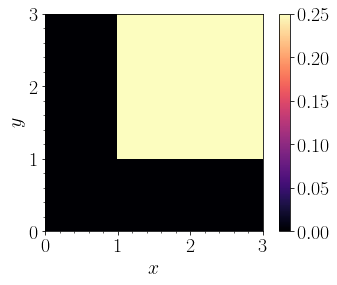

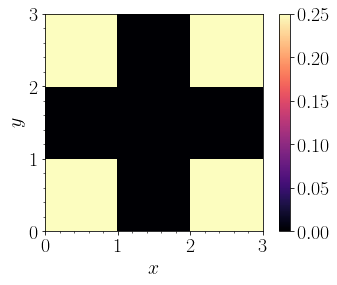

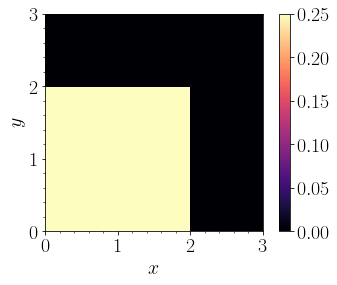

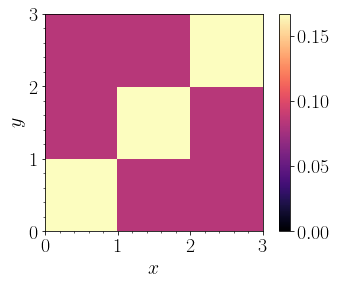

In [5]:
cmap = 'magma'

def plot_format(ax):
    ax.set_aspect('equal')
    ax.set_xlim(0, components)
    ax.set_ylim(0, components)
    ax.set_xlabel('$x$')
    ax.set_ylabel('$y$')
    ax.set_xticks(range(components+1))
    ax.set_yticks(range(components+1))
    ax.xaxis.set_minor_locator(AutoMinorLocator())
    ax.yaxis.set_minor_locator(AutoMinorLocator())

x = np.linspace(0, components, 500)
y = np.linspace(0, components, 500)
x, y = np.meshgrid(x, y)

for i in range(components):
    fig, ax = plt.subplots()
    z = comp_x_pdf(i, x) * comp_y_pdf(i, y)
    _ = plt.pcolormesh(x, y, z, rasterized=True, cmap=cmap)
    plot_format(ax)
    plt.colorbar(_)
    plt.savefig(figname(f'heatmap_comp_{i+1}.pdf'), bbox_inches='tight')

fig, ax = plt.subplots()
z = xy_pdf(x, y)
_ = plt.pcolormesh(x, y, z, rasterized=True, cmap=cmap, vmin=0)
plt.colorbar(_)
plot_format(ax)
plt.savefig(figname('heatmap_combined.pdf'), bbox_inches='tight')

## Building individual classifier networks for the different variates:

In [6]:
tf.random.set_seed(1)
class_count = components

model_x = keras.Sequential()
model_x.add(keras.Input(x_input_shape))
model_x.add(klayers.Dense(32, activation='relu'))
model_x.add(klayers.Dense(32, activation='relu'))
model_x.add(klayers.Dense(32, activation='relu'))
model_x.add(klayers.Dense(class_count, activation='softmax'))

model_y = keras.Sequential()
model_y.add(keras.Input(y_input_shape))
model_y.add(klayers.Dense(32, activation='relu'))
model_y.add(klayers.Dense(32, activation='relu'))
model_y.add(klayers.Dense(32, activation='relu'))
model_y.add(klayers.Dense(class_count, activation='softmax'))

## Making an InClass Net out of the individual classifier networks:

In [7]:
inclass_model = rd6.InClassNet([model_x, model_y])
inclass_model.summary()

Model: "in_class_net"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 32)           64          input_1[0][0]                    
__________________________________________________________________________________________________
dense_4 (Dense)                 (None, 32)           64          input_2[0][0]                    
_______________________________________________________________________________________

## Compiling and fitting the model:

In [8]:
inclass_model.compile(optimizer='adam', loss=rd6.losses.neg_ctc_cost)

In [9]:
inclass_model.fit(x=[sample_x, sample_y], y='dummy', batch_size=50, epochs=30)

Epoch 1/30
Instructions for updating:
This op will be removed after the deprecation date. Please switch to tf.sets.difference().
2000/2000 [==============================] - 4s 2ms/step - loss: -0.0334
Epoch 2/30
2000/2000 [==============================] - 4s 2ms/step - loss: -0.0477
Epoch 3/30
2000/2000 [==============================] - 4s 2ms/step - loss: -0.0500
Epoch 4/30
2000/2000 [==============================] - 4s 2ms/step - loss: -0.0510
Epoch 5/30
2000/2000 [==============================] - 4s 2ms/step - loss: -0.0520
Epoch 6/30
2000/2000 [==============================] - 4s 2ms/step - loss: -0.0524
Epoch 7/30
2000/2000 [==============================] - 4s 2ms/step - loss: -0.0524
Epoch 8/30
2000/2000 [==============================] - 4s 2ms/step - loss: -0.0534
Epoch 9/30
2000/2000 [==============================] - 4s 2ms/step - loss: -0.0533
Epoch 10/30
2000/2000 [==============================] - 4s 2ms/step - loss: -0.0530
Epoch 11/30
2000/2000 [==================

## Postprocessing the network outputs:

In [10]:
predictions = inclass_model.predict([sample_x, sample_y])
model_postprocess = inclass_utils.postprocess(predictions)

print("model_postprocess is a dict containing the following keys:")
for key in model_postprocess:
    print(f"  * '{key}'")

model_postprocess is a dict containing the following keys:
  * 'pseudo_weights'
  * 'norm_weights'
  * 'balanced_classifier_outputs'
  * 'aggregate_classifier_output'
  * 'unnorm_neg_ctc_cost'
  * 'neg_ctc_cost'


## Learned model vs True model comparison:

In [11]:
print("neg_ctc_cost")
print("  * true classifiers:", inclass_utils.get_neg_ctc_cost(true_classifiers([sample_x, sample_y])))
print("  * learned classifiers:", model_postprocess['neg_ctc_cost'])

neg_ctc_cost
  * true classifiers: -0.05946893105921053
  * learned classifiers: -0.05682098


In [12]:
print("Component weights:")
print("  * true:", list(w))
print("  * learned:", list(model_postprocess['norm_weights']))

Component weights:
  * true: [0.3333333333333333, 0.3333333333333333, 0.3333333333333333]
  * learned: [0.17032816, 0.66866314, 0.16100866]


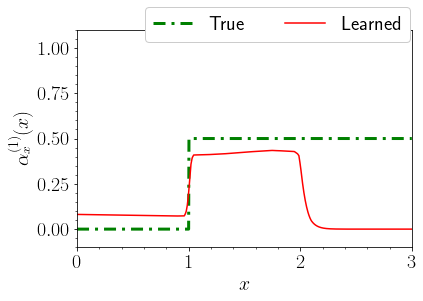

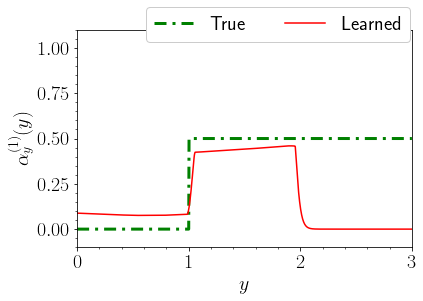

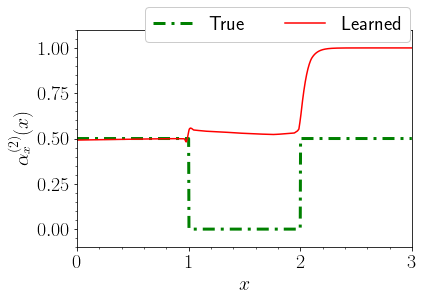

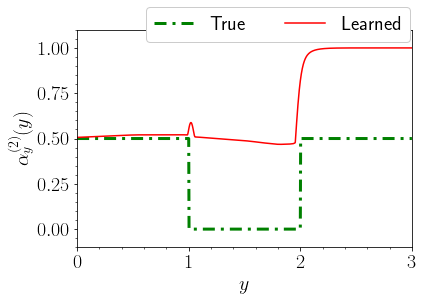

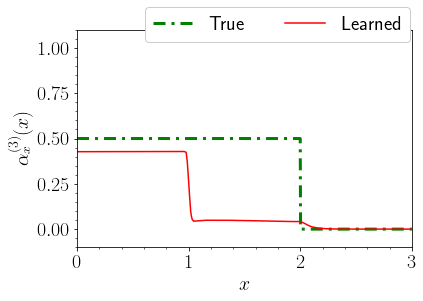

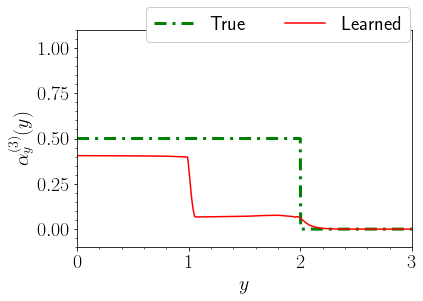

In [13]:
def plot_format(ax):
    ax.set_xticks(range(components+1))
    ax.set_xlim(0, components)
    ax.set_ylim(-.1, 1.1)
    ax.legend(loc='upper center', ncol=2, bbox_to_anchor=(0.6, 1.15), framealpha=1.)
    ax.xaxis.set_minor_locator(AutoMinorLocator())
    ax.yaxis.set_minor_locator(AutoMinorLocator())

x = np.linspace(0, components-1e-6, 1000)
raw_x_classifier_output = model_x.predict(x)
balanced_x_classifier_output = inclass_utils.get_balanced_single_classifier_output(y_pred_variate=raw_x_classifier_output,
                                                                                   pseudo_weights_variate=model_postprocess['pseudo_weights'][0], 
                                                                                   weights=model_postprocess['norm_weights'])

y = np.linspace(0, components-1e-6, 1000)
raw_y_classifier_output = model_y.predict(y)
balanced_y_classifier_output = inclass_utils.get_balanced_single_classifier_output(y_pred_variate=raw_y_classifier_output,
                                                                                   pseudo_weights_variate=model_postprocess['pseudo_weights'][1], 
                                                                                   weights=model_postprocess['norm_weights'])

for i in range(components):
    fig, ax = plt.subplots()
    ax.plot(x, comp_classify_x(i, x), color='green', linestyle=(0, (4,2,1,2)), linewidth=3, label='True')
    ax.plot(x, balanced_x_classifier_output[:,i], color='red', label='Learned')
    ax.set_xlabel(r'$x$')
    ax.set_ylabel(r'$\alpha^{(%d)}_x(x)$' % (i+1,))
    plot_format(ax)
    plt.savefig(figname(f'classifier_x_{i+1}.pdf'), bbox_inches='tight')

    fig, ax = plt.subplots()
    ax.plot(y, comp_classify_y(i, y), color='green', linestyle=(0, (4,2,1,2)), linewidth=3, label='True')
    ax.plot(y, balanced_y_classifier_output[:,i], color='red', label='Learned')
    ax.set_xlabel(r'$y$')
    ax.set_ylabel(r'$\alpha^{(%d)}_y(y)$' % (i+1,))
    plot_format(ax)
    plt.savefig(figname(f'classifier_y_{i+1}.pdf'), bbox_inches='tight')

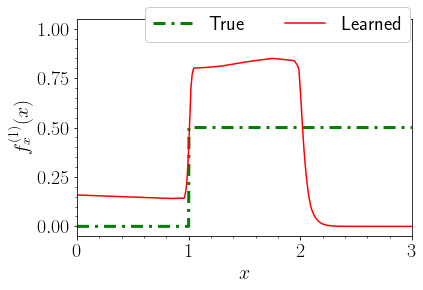

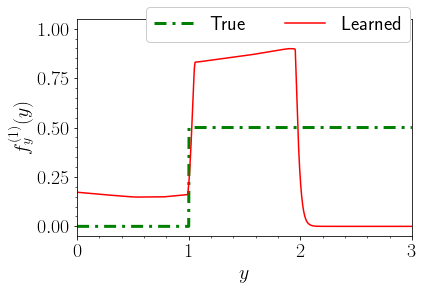

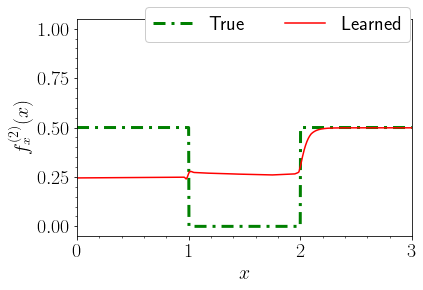

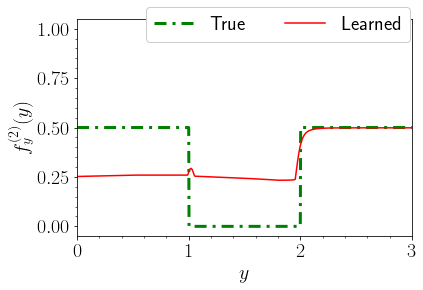

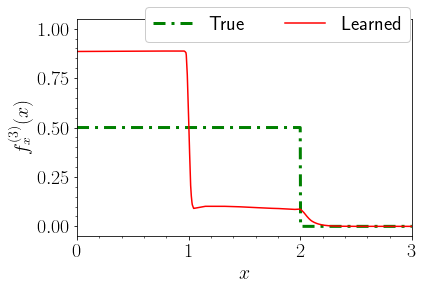

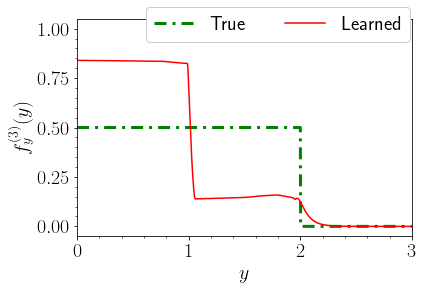

In [14]:
def plot_format(ax):
    ax.set_xticks(range(components+1))
    ax.set_xlim(0, components)
    ax.set_ylim(-.05, 1.05)
    ax.legend(loc='upper center', ncol=2, bbox_to_anchor=(0.6, 1.1), framealpha=1.)
    ax.xaxis.set_minor_locator(AutoMinorLocator())
    ax.yaxis.set_minor_locator(AutoMinorLocator())

for i in range(components):
    fig, ax = plt.subplots()
    ax.plot(x, x_pdf(x)*comp_classify_x(i, x)/w[i], color='green', linestyle=(0, (4,2,1,2)), linewidth=3, label='True')
    ax.plot(x, x_pdf(x)*balanced_x_classifier_output[:,i]/model_postprocess['norm_weights'][i], color='red', label='Learned')
    ax.set_xlabel(r'$x$')
    ax.set_ylabel(r'$f^{(%d)}_x(x)$' % (i+1))
    plot_format(ax)
    plt.savefig(figname(f'compdist_x_{i+1}.pdf'), bbox_inches='tight')

    fig, ax = plt.subplots()
    ax.plot(y, y_pdf(y)*comp_classify_y(i, y)/w[i], color='green', linestyle=(0, (4,2,1,2)), linewidth=3, label='True')
    ax.plot(y, y_pdf(y)*balanced_y_classifier_output[:,i]/model_postprocess['norm_weights'][i], color='red', label='Learned')
    ax.set_xlabel(r'$y$')
    ax.set_ylabel(r'$f^{(%d)}_y(y)$' % (i+1,))
    plot_format(ax)
    plt.savefig(figname(f'compdist_y_{i+1}.pdf'), bbox_inches='tight')